In [1]:
from fuzzyART_gai import *
from kit_handy import *
from kit_painting import *
import matplotlib.pyplot as plt

In [2]:
data, label_true = load_data('gaussian2d') # iris
pca_painter = PaintPCA(data)

Variance explained by first 2 principal components: [0.86531684 0.13468316]


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
Category 6 is too small
0.9
Category 13 is too small
Category 16 is too small
Category 17 is too small
Category 18 is too small
1.0
Category 0 is too small
Category 1 is too small
Category 2 is too small
Category 3 is too small
Category 4 is too small
Category 5 is too small
Category 6 is too small
Category 7 is too small
Category 8 is too small
Category 9 is too small
Category 10 is too small
Category 11 is too small
Category 12 is too small
Category 13 is too small
Category 14 is too small
Category 15 is too small
Category 16 is too small
Category 18 is too small
Category 19 is too small
Category 20 is too small
Category 21 is too small
Category 22 is too small
Category 23 is too small
Category 24 is too small
Category 25 is too small
Category 26 is too small
Category 27 is too small
Category 28 is too small
Category 29 is too small
Category 31 is too small
Category 32 is too small
Category 33 is too sm

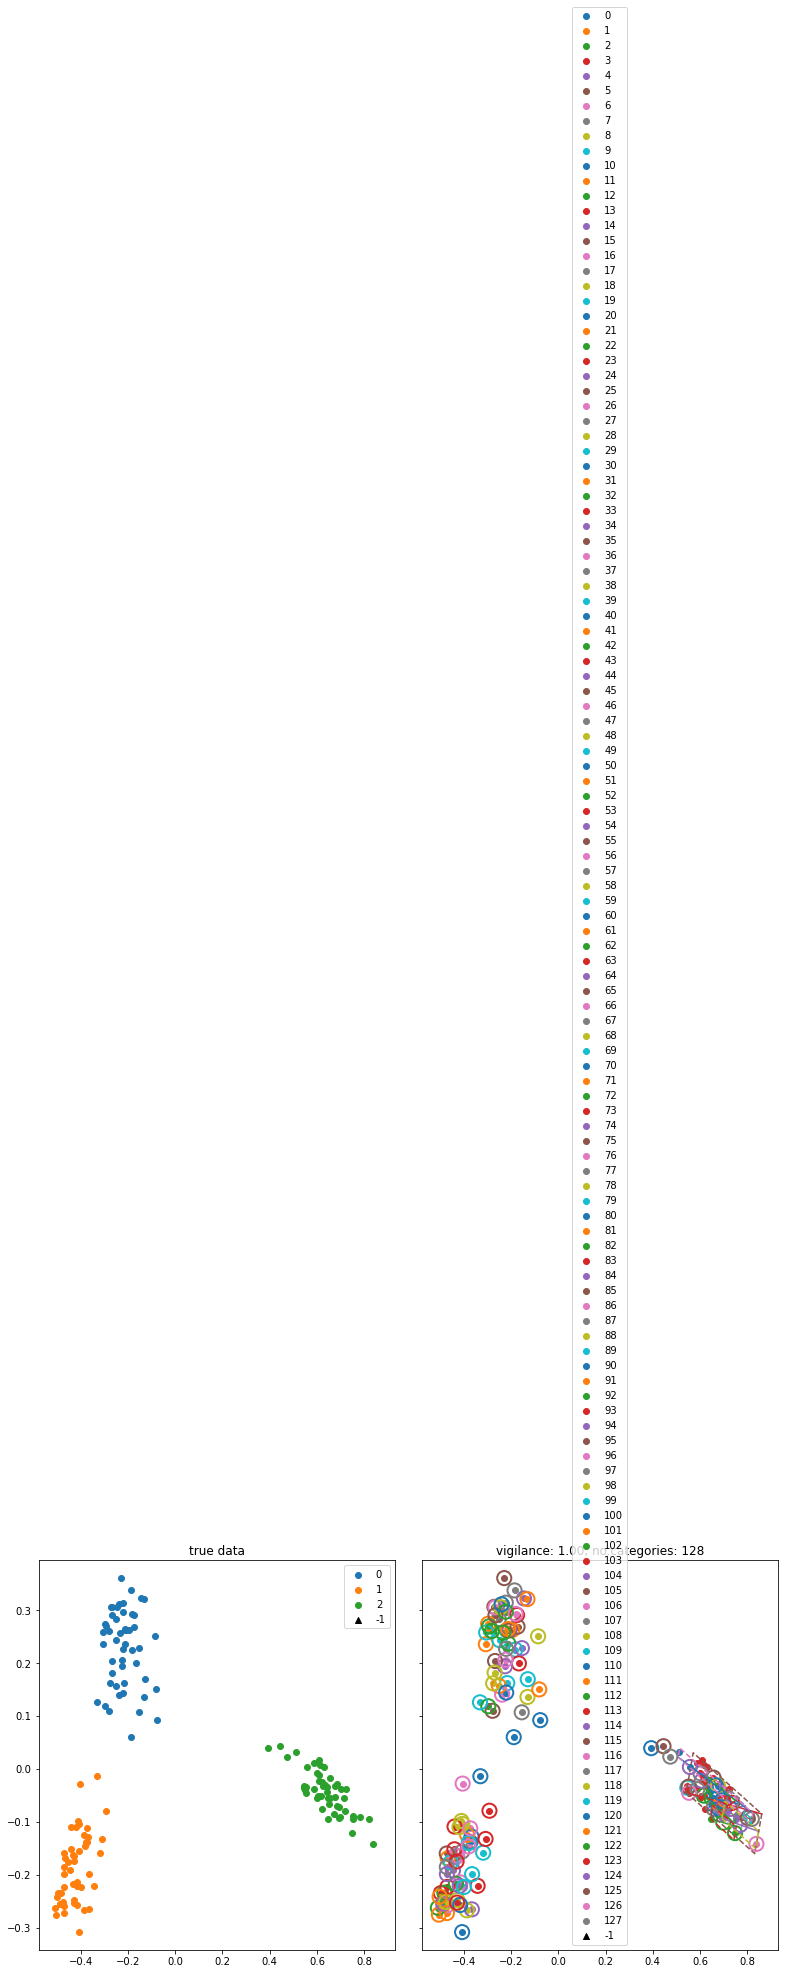

In [19]:
no_rho = 11
ls_rho = np.linspace(0, 1, no_rho)
fig, axs = plt.subplots(1, 2,
                        figsize = (11, 6), sharex=True, sharey=True)
fig.tight_layout()

# plot true data
pca_painter.scatter(axs[0], label_true)
axs[0].set_title("true data")

for rho in ls_rho: #[.5]:#
    print(rho)
    
    axs[1].clear()
    # init
    net = FuzzyART(alpha=0.5, rho=rho)
    
    # train
    net.train(data, epochs=100) # each epoch, all data is shuffled
    label_pred = net.test(data).astype(int)

    # plot
    # pred
    pca_painter.scatter(axs[1], label_pred, data)
    
    # bipole and centre
    pca_painter.tripole(axs[1], *net.getcat_bipole())
    
    # boundary    
    axs[1].set_prop_cycle(None)
    pca_painter.boundary(axs[1], net.getcat_vertex())
    
    # info
    cat_number = net.w.shape[0]
    axs[1].set_title('vigilance: {:.2f}, no.categories: {}'.format(rho, cat_number))
    
   
    # save fig
    simname = 'var_rho{:d}'.format(int(rho*100))
    dirname = '_simcache'
    #savefigure_datetime(fig, simname, dirname)
    


In [4]:
net.__dict__.keys()

dict_keys(['alpha', 'beta', 'gamma', 'rho', 'complement_coding', 'w', 'featnum'])

In [16]:
np.all(np.array([1,1]) == False)

False

In [18]:
np.any([1,1])

True